In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, f_oneway

In [37]:
# Set up the date range for the year
idx = pd.date_range(start='2023-01-01', end='2023-12-31', freq="h")

In [4]:
# Set a random seed for reproducibility
rng = np.random.default_rng(seed=42)

In [5]:
# Define the average wait times in minutes
mean_wait_time = 60

In [6]:
# Create a sine curve to reflect the changing average wait times throughout the day
# Simulate lower wait times during early morning and late night, higher in afternoon and evening
x = np.linspace(-np.pi, np.pi, 24)
means = (np.sin(x) * (mean_wait_time / 3)) + mean_wait_time

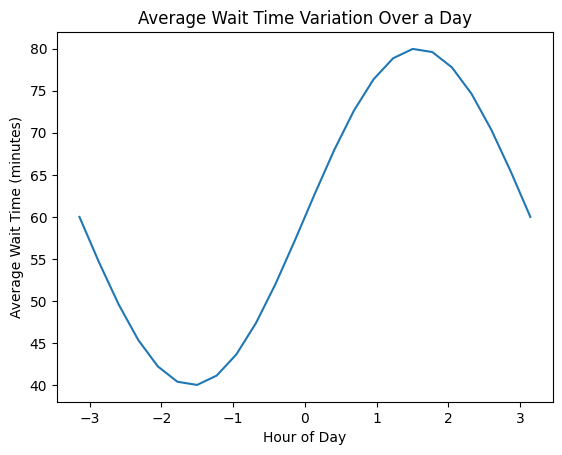

In [7]:
# Plot to visualize the average wait time pattern over a 24-hour period
plt.plot(x, means)
plt.title("Average Wait Time Variation Over a Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (minutes)")
plt.show()

In [51]:
# Expanded the sine wave pattern to match the total number of data points in hours
number_of_days = len(idx) / 24
multiplier = (number_of_days * 2) - 1
x_extended = np.linspace(-np.pi, multiplier * np.pi, len(idx))
wait_time_means = (np.sin(x_extended) * (mean_wait_time / 3)) + mean_wait_time

In [10]:
# Generate wait times based on the Poisson distribution
df = pd.DataFrame(index=idx, data=rng.poisson(lam=wait_time_means, size=len(idx)), columns=["wait_time_minutes"])

In [32]:
# Feature for the day of the week
df['day_of_week'] = df.index.day_name()

In [38]:
# Seasonality Feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df['season'] = df.index.month.map(get_season)

In [24]:
# Holiday Feature
def is_holiday(date):
    holidays = [
        datetime(2023, 1, 1),  # New Year's Day
        datetime(2023, 3, 17), # St. Patrick's Day
        datetime(2023, 12, 25), # Christmas
        datetime(2023, 12, 26), # St. Stephen's Day
    ]
    return 1 if date.date() in [holiday.date() for holiday in holidays] else 0

df['is_holiday'] = df.index.map(is_holiday)

In [39]:
# Feature for full moon days
full_moon_dates = [
    datetime(2023, 1, 6), 
    datetime(2023, 2, 5),
    datetime(2023, 3, 7),
    datetime(2023, 4, 6),
    datetime(2023, 5, 5),
    datetime(2023, 6, 4),
    datetime(2023, 7, 3),
    datetime(2023, 8, 1),
    datetime(2023, 8, 30),
    datetime(2023, 9, 29),
    datetime(2023, 10, 28),
    datetime(2023, 11, 27),
    datetime(2023, 12, 26),
]

def is_full_moon(date):
    return 1 if date.date() in [full_moon.date() for full_moon in full_moon_dates] else 0

df['is_full_moon'] = df.index.map(is_full_moon)

In [44]:
# Day or Night feature
def day_or_night(hour):
    if 7 <= hour < 19:
        return 'Day'
    else:
        return 'Night'

df['day_or_night'] = df.index.hour.map(day_or_night)

In [52]:
# Adjust Wait Times for Weekends, Summer, and Winter
def adjust_wait_times(row):
    wait_time = row['wait_time_minutes']

    # Increase wait times by 20% for weekends
    if row['day_of_week'] in ['Saturday', 'Sunday']:
        wait_time *= 1.2

    # Increase wait times by 15% for Summer and Winter
    if row['season'] in ['Summer', 'Winter']:
        wait_time *= 1.15

    return wait_time

In [59]:
# Apply the adjustment function to create a new column with adjusted wait times
df['adjusted_wait_time_minutes'] = df.apply(adjust_wait_times, axis=1)

In [53]:
# Preview the updated DataFrame
print(df.head(10))

                     wait_time_minutes day_of_week  season  is_holiday  \
2023-01-01 00:00:00                 67      Sunday  Winter           1   
2023-01-01 01:00:00                 64      Sunday  Winter           1   
2023-01-01 02:00:00                 56      Sunday  Winter           1   
2023-01-01 03:00:00                 37      Sunday  Winter           1   
2023-01-01 04:00:00                 40      Sunday  Winter           1   
2023-01-01 05:00:00                 43      Sunday  Winter           1   
2023-01-01 06:00:00                 39      Sunday  Winter           1   
2023-01-01 07:00:00                 42      Sunday  Winter           1   
2023-01-01 08:00:00                 50      Sunday  Winter           1   
2023-01-01 09:00:00                 52      Sunday  Winter           1   

                     is_full_moon day_or_night  
2023-01-01 00:00:00             0        Night  
2023-01-01 01:00:00             0        Night  
2023-01-01 02:00:00             0     

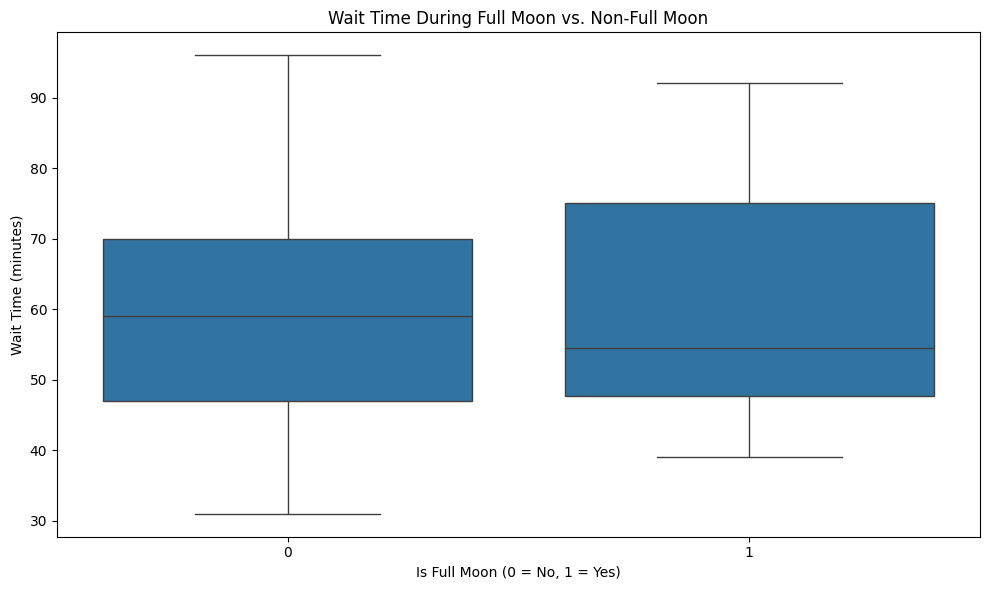

In [54]:
# Plot to visualize the wait times by whether it's a full moon
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_full_moon', y='wait_time_minutes', data=df)
plt.title("Wait Time During Full Moon vs. Non-Full Moon")
plt.xlabel("Is Full Moon (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

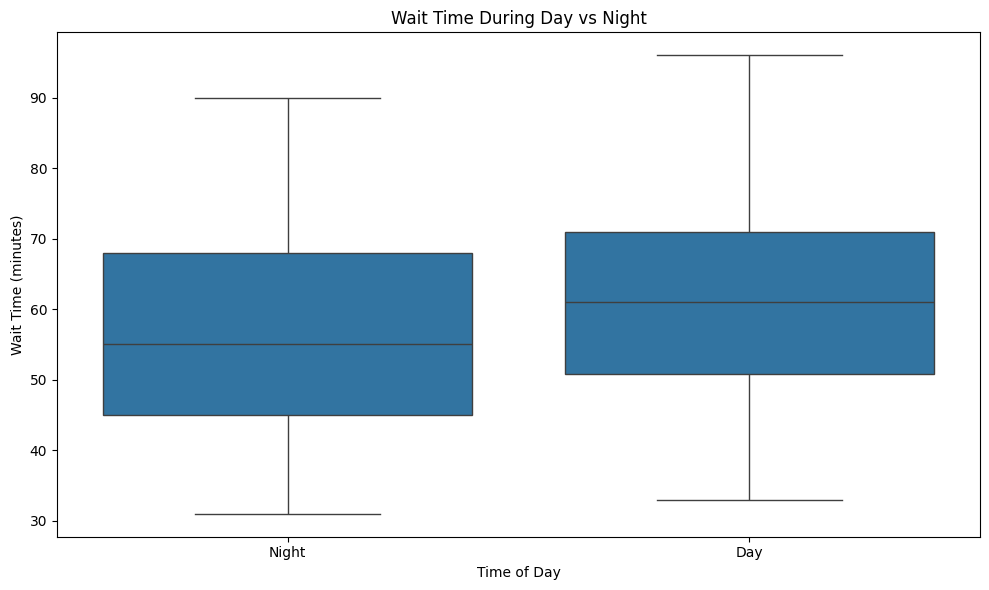

In [46]:
# Plot to visualize the wait times by day or night
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_or_night', y='wait_time_minutes', data=df)
plt.title("Wait Time During Day vs Night")
plt.xlabel("Time of Day")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

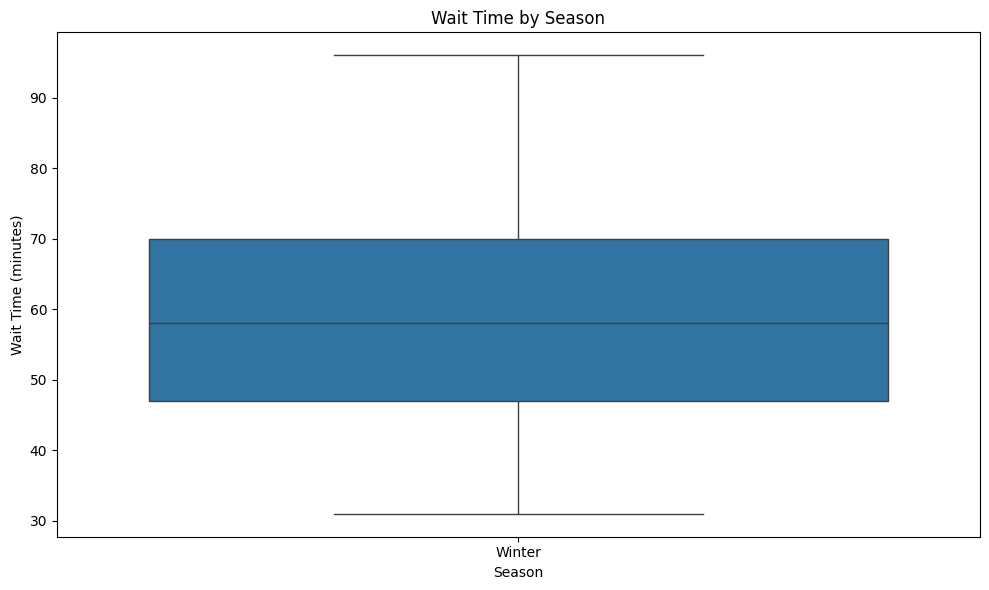

In [27]:
# Visualize Seasonal Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='wait_time_minutes', data=df)
plt.title("Wait Time by Season")
plt.xlabel("Season")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

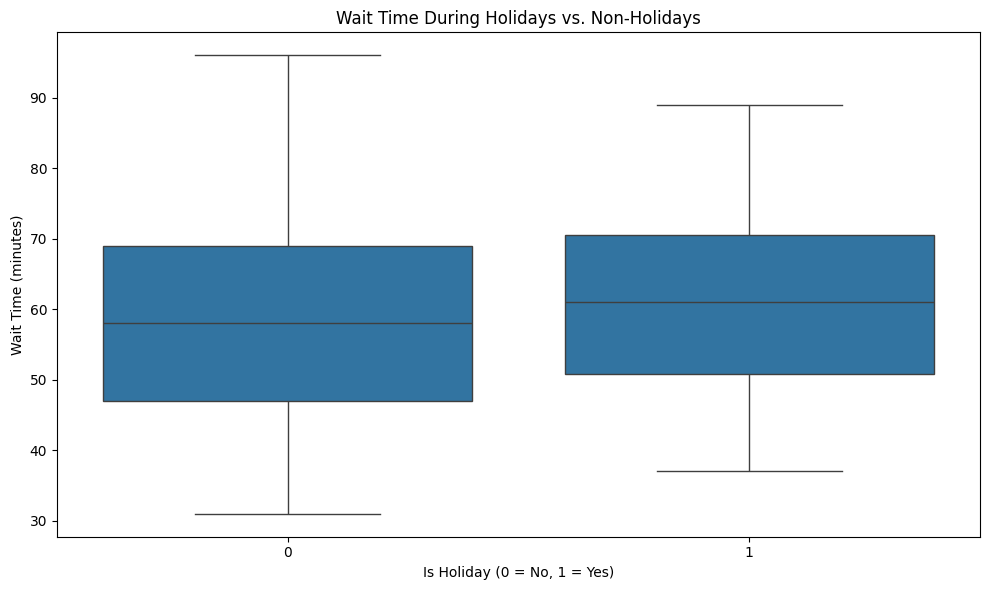

In [28]:
# Visualize Holiday Impact on Wait Times
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='wait_time_minutes', data=df)
plt.title("Wait Time During Holidays vs. Non-Holidays")
plt.xlabel("Is Holiday (0 = No, 1 = Yes)")
plt.ylabel("Wait Time (minutes)")
plt.tight_layout()
plt.show()

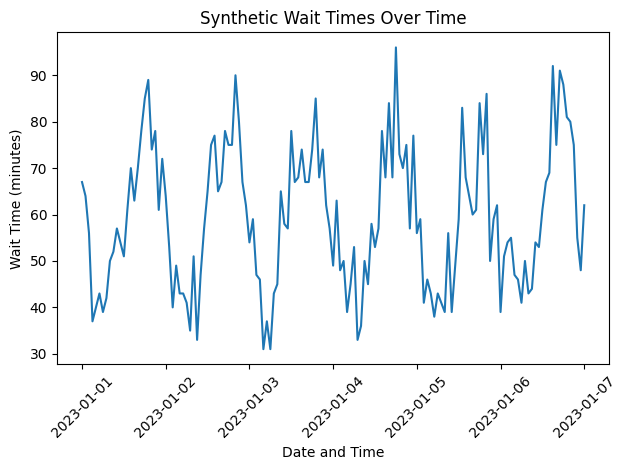

In [55]:
# Plot the synthetic data to see how the wait times fluctuate
sns.lineplot(data=df, x=df.index, y="wait_time_minutes")
plt.title("Synthetic Wait Times Over Time")
plt.xlabel("Date and Time")
plt.ylabel("Wait Time (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# Check the average wait time in the generated data
print("Average Wait Time:", df["wait_time_minutes"].mean())

Average Wait Time: 59.33793103448276


In [60]:
# Step 3.1: T-Test for Full Moon vs Non-Full Moon (using adjusted wait times)
full_moon_wait_times = df[df['is_full_moon'] == 1]['adjusted_wait_time_minutes']
non_full_moon_wait_times = df[df['is_full_moon'] == 0]['adjusted_wait_time_minutes']

t_stat, p_value = ttest_ind(full_moon_wait_times, non_full_moon_wait_times, equal_var=False)
print("T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):")
print("T-Statistic:", t_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between full moon and non-full moon days.")
else:
    print("There is no significant difference in adjusted wait times between full moon and non-full moon days.")
print("\n")

# Step 3.2: ANOVA for Season Comparison (using adjusted wait times)
winter_wait_times = df[df['season'] == 'Winter']['adjusted_wait_time_minutes']
spring_wait_times = df[df['season'] == 'Spring']['adjusted_wait_time_minutes']
summer_wait_times = df[df['season'] == 'Summer']['adjusted_wait_time_minutes']
autumn_wait_times = df[df['season'] == 'Autumn']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(winter_wait_times, spring_wait_times, summer_wait_times, autumn_wait_times)
print("ANOVA Test for Seasons (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between different seasons.")
else:
    print("There is no significant difference in adjusted wait times between different seasons.")
print("\n")

# Step 3.3: ANOVA for Day vs Night (using adjusted wait times)
day_wait_times = df[df['day_or_night'] == 'Day']['adjusted_wait_time_minutes']
night_wait_times = df[df['day_or_night'] == 'Night']['adjusted_wait_time_minutes']

f_stat, p_value = f_oneway(day_wait_times, night_wait_times)
print("ANOVA Test for Day vs Night (Adjusted Wait Times):")
print("F-Statistic:", f_stat)
print("P-Value:", p_value)
if p_value < 0.05:
    print("There is a significant difference in adjusted wait times between day and night.")
else:
    print("There is no significant difference in adjusted wait times between day and night.")

T-Test Full Moon vs Non-Full Moon (Adjusted Wait Times):
T-Statistic: -0.20491228723922925
P-Value: 0.8389127037136193
There is no significant difference in adjusted wait times between full moon and non-full moon days.


ANOVA Test for Seasons (Adjusted Wait Times):
F-Statistic: nan
P-Value: nan
There is no significant difference in adjusted wait times between different seasons.


ANOVA Test for Day vs Night (Adjusted Wait Times):
F-Statistic: 2.644904406492912
P-Value: 0.10608410103830973
There is no significant difference in adjusted wait times between day and night.


/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):
